In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn import preprocessing
from sklearn.cluster import KMeans, OPTICS, MeanShift, Birch, DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.mixture import GaussianMixture
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import homogeneity_completeness_v_measure, accuracy_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score, completeness_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
import psutil
np.set_printoptions(precision=3, linewidth=100)
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
#git.Repo.clone_from("https://github.com/petrobras/3W.git", "datasets")

In [3]:
from pathlib import Path

def read_csv_files(folder_path):
    dfs = []  # List to store the DataFrames from each file
    path = Path(folder_path)  # Convert the folder path to a Path object
    for file in path.glob("WELL*.csv"):
        df = pd.read_csv(file)
        dfs.append(df)
    return dfs

def read_datasets(folder_paths):
    all_dfs = []  # List to store DataFrames from all folders
    for folder_path in folder_paths:
        dfs = read_csv_files(folder_path)
        all_dfs.extend(dfs)
    return all_dfs

In [4]:
# Specify the folder paths for the datasets you want to read
folder_paths = [
    "dataset/1",
    "dataset/2",
    "dataset/5",
    "dataset/6"
]

# Call the read_datasets function to read the datasets
datasets = read_datasets(folder_paths)

In [7]:
import random

train_datasets = []
test_datasets = []

for folder_path in folder_paths:
    dfs = read_csv_files(folder_path)
    if folder_path in ["dataset/2", "dataset/5", "dataset/6"]:
        train_datasets.extend(dfs)
    elif folder_path in ["dataset/1"]:
        test_datasets.extend(dfs)  

# Shuffle the order of datasets within the training and testing sets
random.shuffle(train_datasets)
random.shuffle(test_datasets)

# Print the number of datasets in each set
print("Number of datasets for training:", len(train_datasets))
print("Number of datasets for testing:", len(test_datasets))

Number of datasets for training: 39
Number of datasets for testing: 5


In [8]:
# Combine all training datasets into one big training dataset
train_data = pd.concat(train_datasets, ignore_index=True)

# Combine all testing datasets into one big testing dataset
test_data = pd.concat(test_datasets, ignore_index=True)

# Print the shape of the combined training and testing datasets
print("Shape of the training dataset:", train_data.shape)
print("Shape of the testing dataset:", test_data.shape)

Shape of the training dataset: (803340, 10)
Shape of the testing dataset: (312136, 10)


## Data preperation

### Clean Data: Remove Column with empty values

In [9]:
# Perform cleaning to remove columns with missing values

cleaned_training = train_data.dropna(axis='columns', how='all')  # Remove columns with missing values
cleaned_training = cleaned_training.dropna(axis=0)  # Remove rows with missing values
cleaned_training.isnull().sum()

timestamp     0
P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
QGL           0
class         0
dtype: int64

In [8]:
#cleaned_training.head()

In [9]:
cleaned_test = test_data.dropna(axis='columns', how='all')  # Remove columns with missing values
cleaned_test = cleaned_test.dropna(axis=0)  # Remove rows with missing values
cleaned_test.isnull().sum()

timestamp     0
P-PDG         0
P-TPT         0
T-TPT         0
P-MON-CKP     0
T-JUS-CKP     0
P-JUS-CKGL    0
QGL           0
class         0
dtype: int64

In [10]:
print("Shape of the training dataset:", cleaned_training.shape)
print("Shape of the testing dataset:", cleaned_test.shape)

Shape of the training dataset: (530478, 9)
Shape of the testing dataset: (301451, 9)


In [11]:
cleaned_training['class'].value_counts()

105.0    317565
0.0      171612
6.0       12427
5.0       12069
102.0      9307
106.0      4461
2.0        3037
Name: class, dtype: int64

In [12]:
cleaned_test['class'].value_counts()

0.0      195376
101.0     95658
1.0       10417
Name: class, dtype: int64

In [13]:
# Deal with timestamp

# Convert timestamp column to datetime format
cleaned_training['timestamp'] = pd.to_datetime(cleaned_training['timestamp'])
cleaned_test['timestamp'] = pd.to_datetime(cleaned_test['timestamp'])

# Extract components from timestamp
cleaned_training['year'] = cleaned_training['timestamp'].dt.year
cleaned_training['month'] = cleaned_training['timestamp'].dt.month
cleaned_training['day'] = cleaned_training['timestamp'].dt.day
cleaned_training['hour'] = cleaned_training['timestamp'].dt.hour
# Extract additional components if needed

cleaned_test['year'] = cleaned_test['timestamp'].dt.year
cleaned_test['month'] = cleaned_test['timestamp'].dt.month
cleaned_test['day'] = cleaned_test['timestamp'].dt.day
cleaned_test['hour'] = cleaned_test['timestamp'].dt.hour
# Extract additional components if needed

## Scaling each feature to a given range: using MinMaxScaler

In [14]:
#minmax

columns = [col for col in cleaned_training.columns if col not in ['timestamp','class']]
min_max = preprocessing.MinMaxScaler()
cleaned_training[columns] = min_max.fit_transform(cleaned_training[columns])
cleaned_training.head()

cleaned_test[columns] = min_max.transform(cleaned_test[columns])
cleaned_test.head()

print(cleaned_training.head())
print(cleaned_test.head())

                timestamp  P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  \
13890 2014-02-12 17:03:33    0.0  0.002831  0.996182   0.199175   0.427392   
13891 2014-02-12 17:03:34    0.0  0.002831  0.996184   0.199175   0.427392   
13892 2014-02-12 17:03:35    0.0  0.002831  0.996186   0.199175   0.427391   
13893 2014-02-12 17:03:36    0.0  0.002831  0.996188   0.199175   0.427391   
13894 2014-02-12 17:03:37    0.0  0.002831  0.996190   0.199175   0.427391   

       P-JUS-CKGL  QGL  class  year  month   day     hour  
13890    0.002852  0.0    0.0   0.2    0.0  0.44  0.73913  
13891    0.002852  0.0    0.0   0.2    0.0  0.44  0.73913  
13892    0.002852  0.0    0.0   0.2    0.0  0.44  0.73913  
13893    0.002852  0.0    0.0   0.2    0.0  0.44  0.73913  
13894    0.002852  0.0    0.0   0.2    0.0  0.44  0.73913  
            timestamp  P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  \
0 2014-01-24 09:33:03    0.0  0.004747  0.979754   0.977121   0.371816   
1 2014-01-24 09:33:04  

In [15]:
new_training= pd.DataFrame(cleaned_training, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL', 'class', 'year', 'month', 'day', 'hour'])
new_test= pd.DataFrame(cleaned_test, columns=['timestamp', 'P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL', 'class', 'year', 'month', 'day', 'hour'])

In [16]:
X_train = new_training.drop(['timestamp','class'], axis=1)
y_train = new_training['class']

X_test = new_test.drop(['timestamp','class'], axis=1)
y_test = new_test['class']

In [17]:
X_train.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,QGL,year,month,day,hour
13890,0.0,0.002831,0.996182,0.199175,0.427392,0.002852,0.0,0.2,0.0,0.44,0.73913
13891,0.0,0.002831,0.996184,0.199175,0.427392,0.002852,0.0,0.2,0.0,0.44,0.73913
13892,0.0,0.002831,0.996186,0.199175,0.427391,0.002852,0.0,0.2,0.0,0.44,0.73913
13893,0.0,0.002831,0.996188,0.199175,0.427391,0.002852,0.0,0.2,0.0,0.44,0.73913
13894,0.0,0.002831,0.996190,0.199175,0.427391,0.002852,0.0,0.2,0.0,0.44,0.73913


In [18]:
y_train.head()

13890    0.0
13891    0.0
13892    0.0
13893    0.0
13894    0.0
Name: class, dtype: float64

## feature selection

In [19]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(score_func=chi2, k=8)
selector.fit(X_train, y_train)

# Get the selected feature indices
selected_feature_indices_train = selector.get_support(indices=True)

# Get the selected feature names
selected_feature_names_train = [X_train.columns[i] for i in selected_feature_indices_train]

# Subset the training data with selected features
selected_train_data = X_train[selected_feature_names_train]

# Perform feature selection on the scaled test data
selected_features_test = selector.transform(X_test)

# Subset the test data with selected features
selected_test_data = X_test[selected_feature_names_train]

# Print the selected feature names
print("Selected features:", selected_feature_names_train)

Selected features: ['P-PDG', 'P-TPT', 'T-TPT', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL', 'year', 'month']


In [20]:
selected_train_data.head()

,P-PDG,P-TPT,T-TPT,T-JUS-CKP,P-JUS-CKGL,QGL,year,month
13890,0.0,0.002831,0.996182,0.427392,0.002852,0.0,0.2,0.0
13891,0.0,0.002831,0.996184,0.427392,0.002852,0.0,0.2,0.0
13892,0.0,0.002831,0.996186,0.427391,0.002852,0.0,0.2,0.0
13893,0.0,0.002831,0.996188,0.427391,0.002852,0.0,0.2,0.0
13894,0.0,0.002831,0.996190,0.427391,0.002852,0.0,0.2,0.0


In [21]:
selected_test_data.head()

,P-PDG,P-TPT,T-TPT,T-JUS-CKP,P-JUS-CKGL,QGL,year,month
0,0.0,0.004747,0.979754,0.371816,-0.000144,0.0,0.2,-0.1
1,0.0,0.004747,0.979754,0.371816,-0.000144,0.0,0.2,-0.1
2,0.0,0.004747,0.979754,0.371816,-0.000144,0.0,0.2,-0.1
3,0.0,0.004747,0.979754,0.371816,-0.000144,0.0,0.2,-0.1
4,0.0,0.004747,0.979754,0.371816,-0.000144,0.0,0.2,-0.1


In [22]:
print("Shape of the training dataset:", selected_train_data.shape)

Shape of the training dataset: (530478, 8)


In [23]:
X_train = selected_train_data

X_test = selected_test_data

In [24]:
X_train.head()

,P-PDG,P-TPT,T-TPT,T-JUS-CKP,P-JUS-CKGL,QGL,year,month
13890,0.0,0.002831,0.996182,0.427392,0.002852,0.0,0.2,0.0
13891,0.0,0.002831,0.996184,0.427392,0.002852,0.0,0.2,0.0
13892,0.0,0.002831,0.996186,0.427391,0.002852,0.0,0.2,0.0
13893,0.0,0.002831,0.996188,0.427391,0.002852,0.0,0.2,0.0
13894,0.0,0.002831,0.996190,0.427391,0.002852,0.0,0.2,0.0


In [25]:
#def get_memory_usage():
#    process = psutil.Process()
#    return process.memory_info().rss

# Supervised machine learning

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize the classifiers
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier()
gaussian_nb = GaussianNB()
logreg = LogisticRegression(multi_class='auto')

# Initialize the cross-validation strategy
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation for each classifier
rf_scores = cross_val_score(random_forest, X_train, y_train, cv=cv, scoring='accuracy')
knn_scores = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')
dt_scores = cross_val_score(decision_tree, X_train, y_train, cv=cv, scoring='accuracy')
nb_scores = cross_val_score(gaussian_nb, X_train, y_train, cv=cv, scoring='accuracy')
logreg_scores = cross_val_score(logreg, X_train, y_train, cv=cv, scoring='accuracy')

# Compute the mean accuracy across all folds
rf_mean_accuracy = rf_scores.mean()
knn_mean_accuracy = knn_scores.mean()
dt_mean_accuracy = dt_scores.mean()
nb_mean_accuracy = nb_scores.mean()
logreg_mean_accuracy = logreg_scores.mean()

# Fit the classifiers on the full training data
random_forest.fit(X_train, y_train)
knn.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)
gaussian_nb.fit(X_train, y_train)
logreg.fit(X_train, y_train)

# Make predictions on the test data
rf_predictions = random_forest.predict(X_test)
knn_predictions = knn.predict(X_test)
dt_predictions = decision_tree.predict(X_test)
nb_predictions = gaussian_nb.predict(X_test)
logreg_predictions = logreg.predict(X_test)

# Evaluate the performance of each classifier using accuracy score
rf_accuracy = accuracy_score(y_test, rf_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
nb_accuracy = accuracy_score(y_test, nb_predictions)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)

# Print the cross-validated accuracies
print("Random Forest Cross-Validated Accuracy:", rf_mean_accuracy)
print("KNN Cross-Validated Accuracy:", knn_mean_accuracy)
print("Decision Tree Cross-Validated Accuracy:", dt_mean_accuracy)
print("GaussianNB Cross-Validated Accuracy:", nb_mean_accuracy)
print("Logistic Regression Cross-Validated Accuracy:", logreg_mean_accuracy)

# Print the accuracy of each classifier on the test data
print("Random Forest Accuracy:", rf_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("GaussianNB Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Print the classification reports for each classifier
print("Random Forest:")
print(classification_report(y_test, rf_predictions))

print("KNN:")
print(classification_report(y_test, knn_predictions))

print("Decision Tree:")
print(classification_report(y_test, dt_predictions))

print("GaussianNB:")
print(classification_report(y_test, nb_predictions))

print("Logistic Regression:")
print(classification_report(y_test, logreg_predictions))


Random Forest Cross-Validated Accuracy: 0.9473097828116746
KNN Cross-Validated Accuracy: 0.934871943787287
Decision Tree Cross-Validated Accuracy: 0.9396299174853813
GaussianNB Cross-Validated Accuracy: 0.7274703176059499
Logistic Regression Cross-Validated Accuracy: 0.8207559884801189
Random Forest Accuracy: 0.35902684018298164
KNN Accuracy: 0.5021015024000584
Decision Tree Accuracy: 0.28909175952310656
GaussianNB Accuracy: 0.6323448918729744
Logistic Regression Accuracy: 0.35902684018298164
Random Forest:
              precision    recall  f1-score   support

         0.0       0.58      0.55      0.57    195376
         1.0       0.00      0.00      0.00     10417
         6.0       0.00      0.00      0.00         0
       101.0       0.00      0.00      0.00     95658

    accuracy                           0.36    301451
   macro avg       0.14      0.14      0.14    301451
weighted avg       0.37      0.36      0.37    301451

KNN:
              precision    recall  f1-score   s

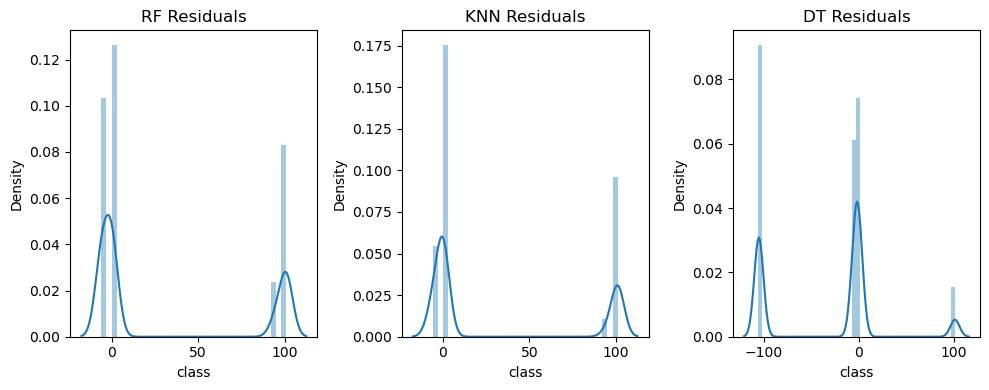

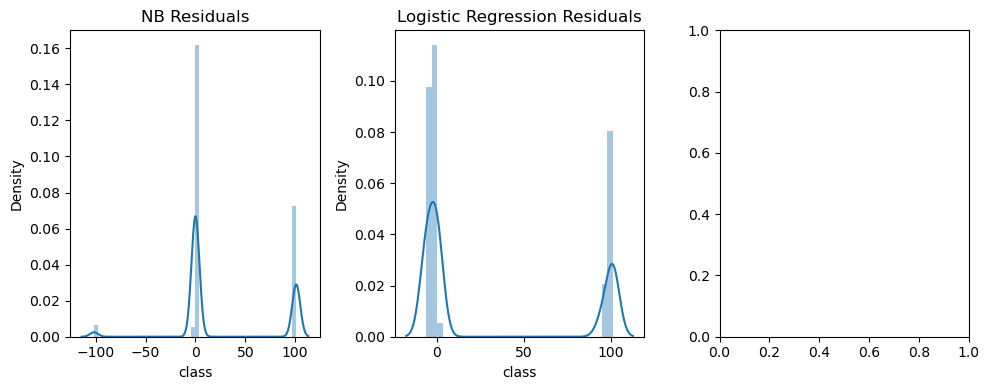

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots with 1 row and 5 columns
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Plot for rf_predictions
sns.distplot((y_test - rf_predictions), ax=axs[0])
axs[0].set_title('RF Residuals')

# Plot for knn_predictions
sns.distplot((y_test - knn_predictions), ax=axs[1])
axs[1].set_title('KNN Residuals')

# Plot for dt_predictions
sns.distplot((y_test - dt_predictions), ax=axs[2])
axs[2].set_title('DT Residuals')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
# Plot for nb_predictions
sns.distplot((y_test - nb_predictions), ax=axs[0])
axs[0].set_title('NB Residuals')

# Plot for logreg_predictions
sns.distplot((y_test - logreg_predictions), ax=axs[1])
axs[1].set_title('Logistic Regression Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Convert the multi-class labels to binary labels
normal_label = 0  # Define the label for the normal class
fault_label = 1   # Define the label for the fault class

# Convert the original labels to binary labels
y_train_binary = [normal_label if label == 0 else fault_label for label in y_train]
y_test_binary = [normal_label if label == 0 else fault_label for label in y_test]

# Initialize the classifiers
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier()
gaussian_nb = GaussianNB()
logreg = LogisticRegression(multi_class='auto')

# Initialize the cross-validation strategy
num_folds = 5
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation for each classifier
rf_scores = cross_val_score(random_forest, X_train, y_train_binary, cv=cv, scoring='accuracy')
knn_scores = cross_val_score(knn, X_train, y_train_binary, cv=cv, scoring='accuracy')
dt_scores = cross_val_score(decision_tree, X_train, y_train_binary, cv=cv, scoring='accuracy')
nb_scores = cross_val_score(gaussian_nb, X_train, y_train_binary, cv=cv, scoring='accuracy')
logreg_scores = cross_val_score(logreg, X_train, y_train_binary, cv=cv, scoring='accuracy')

# Compute the mean accuracy across all folds
rf_mean_accuracy = rf_scores.mean()
knn_mean_accuracy = knn_scores.mean()
dt_mean_accuracy = dt_scores.mean()
nb_mean_accuracy = nb_scores.mean()
logreg_mean_accuracy = logreg_scores.mean()

# Fit the classifiers on the full training data
random_forest.fit(X_train, y_train_binary)
knn.fit(X_train, y_train_binary)
decision_tree.fit(X_train, y_train_binary)
gaussian_nb.fit(X_train, y_train_binary)
logreg.fit(X_train, y_train_binary)

# Make predictions on the test data
rf_predictions = random_forest.predict(X_test)
knn_predictions = knn.predict(X_test)
dt_predictions = decision_tree.predict(X_test)
nb_predictions = gaussian_nb.predict(X_test)
logreg_predictions = logreg.predict(X_test)

# Evaluate the performance of each classifier using accuracy score
rf_accuracy = accuracy_score(y_test_binary, rf_predictions)
knn_accuracy = accuracy_score(y_test_binary, knn_predictions)
dt_accuracy = accuracy_score(y_test_binary, dt_predictions)
nb_accuracy = accuracy_score(y_test_binary, nb_predictions)
logreg_accuracy = accuracy_score(y_test_binary, logreg_predictions)

# Print the cross-validated accuracies
print("Random Forest Cross-Validated Accuracy:", rf_mean_accuracy)
print("KNN Cross-Validated Accuracy:", knn_mean_accuracy)
print("Decision Tree Cross-Validated Accuracy:", dt_mean_accuracy)
print("GaussianNB Cross-Validated Accuracy:", nb_mean_accuracy)
print("Logistic Regression Cross-Validated Accuracy:", logreg_mean_accuracy)

# Print the accuracy of each classifier on the test data
print("Random Forest Accuracy:", rf_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("GaussianNB Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Print the classification reports for each classifier
print("Random Forest:")
print(classification_report(y_test_binary, rf_predictions))

print("KNN:")
print(classification_report(y_test_binary, knn_predictions))

print("Decision Tree:")
print(classification_report(y_test_binary, dt_predictions))

print("GaussianNB:")
print(classification_report(y_test_binary, nb_predictions))

print("Logistic Regression:")
print(classification_report(y_test_binary, logreg_predictions))


Random Forest Cross-Validated Accuracy: 0.9476962290101328
KNN Cross-Validated Accuracy: 0.9357503991434053
Decision Tree Cross-Validated Accuracy: 0.9398674415439157
GaussianNB Cross-Validated Accuracy: 0.7507549749458771
Logistic Regression Cross-Validated Accuracy: 0.8329789322330143
Random Forest Accuracy: 0.6008571874035913
KNN Accuracy: 0.5495486828705163
Decision Tree Accuracy: 0.7791614557589791
GaussianNB Accuracy: 0.6481185997060882
Logistic Regression Accuracy: 0.4572849318794763
Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.45      0.59    195376
           1       0.46      0.89      0.61    106075

    accuracy                           0.60    301451
   macro avg       0.67      0.67      0.60    301451
weighted avg       0.73      0.60      0.60    301451

KNN:
              precision    recall  f1-score   support

           0       0.62      0.77      0.69    195376
           1       0.25      0.13      0.17    1

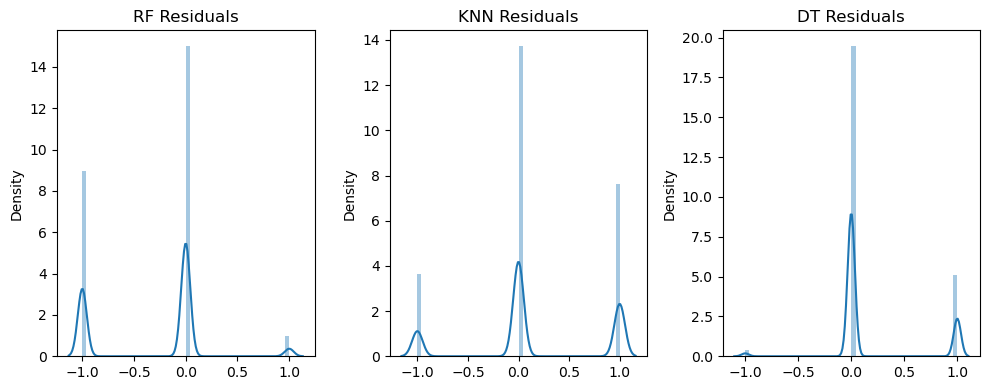

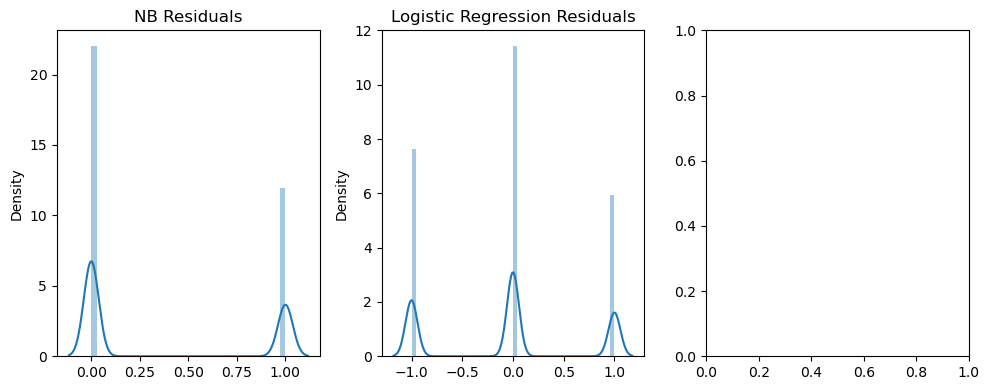

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create subplots with 1 row and 5 columns
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Plot for rf_predictions
sns.distplot((y_test_binary - rf_predictions), ax=axs[0])
axs[0].set_title('RF Residuals')

# Plot for knn_predictions
sns.distplot((y_test_binary - knn_predictions), ax=axs[1])
axs[1].set_title('KNN Residuals')

# Plot for dt_predictions
sns.distplot((y_test_binary - dt_predictions), ax=axs[2])
axs[2].set_title('DT Residuals')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(10, 4))
# Plot for nb_predictions
sns.distplot((y_test_binary - nb_predictions), ax=axs[0])
axs[0].set_title('NB Residuals')

# Plot for logreg_predictions
sns.distplot((y_test_binary - logreg_predictions), ax=axs[1])
axs[1].set_title('Logistic Regression Residuals')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [26]:
from imblearn.over_sampling import SMOTE

#Create an instance of the SMOTE oversampler
smote = SMOTE(random_state=1)

# Resample the training data to balance the classes
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print the balanced class distribution
print("Balanced class distribution in the training data:")
print(y_train_balanced.value_counts())


Balanced class distribution in the training data:
0.0      317565
106.0    317565
6.0      317565
105.0    317565
5.0      317565
102.0    317565
2.0      317565
Name: class, dtype: int64


In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize the classifiers
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier()
gaussian_nb = GaussianNB()
logreg = LogisticRegression(multi_class='auto')

# Fit the classifiers on the full training data
random_forest.fit(X_train_balanced, y_train_balanced)
knn.fit(X_train_balanced, y_train_balanced)
decision_tree.fit(X_train_balanced, y_train_balanced)
gaussian_nb.fit(X_train_balanced, y_train_balanced)
logreg.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test data
rf_predictions = random_forest.predict(X_test)
knn_predictions = knn.predict(X_test)
dt_predictions = decision_tree.predict(X_test)
nb_predictions = gaussian_nb.predict(X_test)
logreg_predictions = logreg.predict(X_test)

# Evaluate the performance of each classifier using accuracy score
rf_accuracy = accuracy_score(y_test, rf_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
nb_accuracy = accuracy_score(y_test, nb_predictions)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)

# Print the accuracy of each classifier on the test data
print("Random Forest Accuracy:", rf_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("GaussianNB Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Print the classification reports for each classifier
print("Random Forest:")
print(classification_report(y_test, rf_predictions))

print("KNN:")
print(classification_report(y_test, knn_predictions))

print("Decision Tree:")
print(classification_report(y_test, dt_predictions))

print("GaussianNB:")
print(classification_report(y_test, nb_predictions))

print("Logistic Regression:")
print(classification_report(y_test, logreg_predictions))


In [25]:
from imblearn.under_sampling import RandomUnderSampler

# Create an instance of the RandomUnderSampler
undersampler = RandomUnderSampler(random_state=1)

# Resample the training data to balance the classes
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Print the balanced class distribution
print("Balanced class distribution in the training data:")
print(y_train_undersampled.value_counts())


Balanced class distribution in the training data:
0.0      3037
2.0      3037
5.0      3037
6.0      3037
102.0    3037
105.0    3037
106.0    3037
Name: class, dtype: int64


In [30]:
from sklearn.naive_bayes import GaussianNB

# Initialize the classifiers
random_forest = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors=5)
decision_tree = DecisionTreeClassifier()
gaussian_nb = GaussianNB()
logreg = LogisticRegression(multi_class='auto')

# Fit the classifiers on the full training data
random_forest.fit(X_train_undersampled, y_train_undersampled)
knn.fit(X_train_undersampled, y_train_undersampled)
decision_tree.fit(X_train_undersampled, y_train_undersampled)
gaussian_nb.fit(X_train_undersampled, y_train_undersampled)
logreg.fit(X_train_undersampled, y_train_undersampled)

# Make predictions on the test data
rf_predictions = random_forest.predict(X_test)
knn_predictions = knn.predict(X_test)
dt_predictions = decision_tree.predict(X_test)
nb_predictions = gaussian_nb.predict(X_test)
logreg_predictions = logreg.predict(X_test)

# Evaluate the performance of each classifier using accuracy score
rf_accuracy = accuracy_score(y_test, rf_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
dt_accuracy = accuracy_score(y_test, dt_predictions)
nb_accuracy = accuracy_score(y_test, nb_predictions)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)

# Print the accuracy of each classifier on the test data
print("Random Forest Accuracy:", rf_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)
print("GaussianNB Accuracy:", nb_accuracy)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Print the classification reports for each classifier
print("Random Forest:")
print(classification_report(y_test, rf_predictions))

print("KNN:")
print(classification_report(y_test, knn_predictions))

print("Decision Tree:")
print(classification_report(y_test, dt_predictions))

print("GaussianNB:")
print(classification_report(y_test, nb_predictions))

print("Logistic Regression:")
print(classification_report(y_test, logreg_predictions))


Random Forest Accuracy: 0.14601709730602982
KNN Accuracy: 0.01577370783311384
Decision Tree Accuracy: 0.14601709730602982
GaussianNB Accuracy: 0.6323448918729744
Logistic Regression Accuracy: 0.3432531323498678
Random Forest:
              precision    recall  f1-score   support

         0.0       0.76      0.23      0.35    195376
         1.0       0.00      0.00      0.00     10417
         6.0       0.00      0.00      0.00         0
       101.0       0.00      0.00      0.00     95658
       105.0       0.00      0.00      0.00         0

    accuracy                           0.15    301451
   macro avg       0.15      0.05      0.07    301451
weighted avg       0.49      0.15      0.23    301451

KNN:
              precision    recall  f1-score   support

         0.0       0.33      0.02      0.05    195376
         1.0       0.00      0.00      0.00     10417
         2.0       0.00      0.00      0.00         0
         6.0       0.00      0.00      0.00         0
       10